In [263]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from casadi import *
mpl.rcParams['font.size'] = 16
#import single_stage.py
#import multi_stage_N1
import MultistageN2 as m
###All the libraries

In [264]:
mpl.rcParams['font.size'] = 16

Defining required system matrices and creating the linear discrete-time system

In [265]:
A=np.array([[1.1,1],[0,1]])
nx=A.shape[1]
B=np.array([[0.5],[1]])
nu=B.shape[1]
x=SX.sym("x",nx,1)
u=SX.sym("u",nu,1)
w=SX.sym("w",2,1)

##Definig system:
x_next=A@x + B@u +w
system = Function("sys",[x,u,w],[x_next])

Checking the system's stability

(-1.3, 1.3)

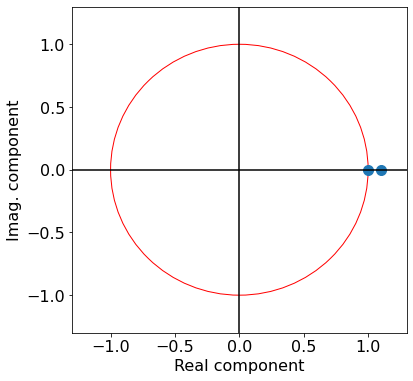

In [266]:
#checking if the system is stable 
lam, v = np.linalg.eig(A)

fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlabel('Real component')
ax.set_ylabel('Imag. component')
ax.add_artist(plt.Circle((0, 0), 1,edgecolor='r', fill=False))
ax.plot(np.real(lam),np.imag(lam),'o', markersize=10)
ax.axhline(0,color='k')
ax.axvline(0,color='k')
ax.set_ylim(-1.3,1.3)
ax.set_xlim(-1.3,1.3)

# obviously unstable since the points are outside the unit circle 

Testing and Plotting the system

In [290]:
# initial states uniformly drawn from Xinit ={x ∈ R2|Hx ≤ h}

x1=np.random.uniform(low=-1.3371, high=1.3371, size=(1,1))
x2=np.random.uniform(low=-1.3350, high=1.3350, size=(1,1))
x_init=np.append(x1,x2).reshape(2,1)

In [267]:

u_k=np.array([0.5])
res_x = [x_0]
for i in range(5):
    w = np.random.uniform(low=-0.25, high=0.25, size=(2,1))
    x_j_k =  system(x_0,u_k,w)
    res_x.append(x_j_k)
    x_0 = x_j_k
    
res_x = np.concatenate(res_x,axis=1)
print(res_x)

[[-0.14854779  0.40596117  1.26036864  2.66921561  4.71410523  7.52231731]
 [ 0.19668706  0.65601873  1.22271541  1.61420868  2.28772093  2.62146722]]


Text(0.5, 0, 'time')

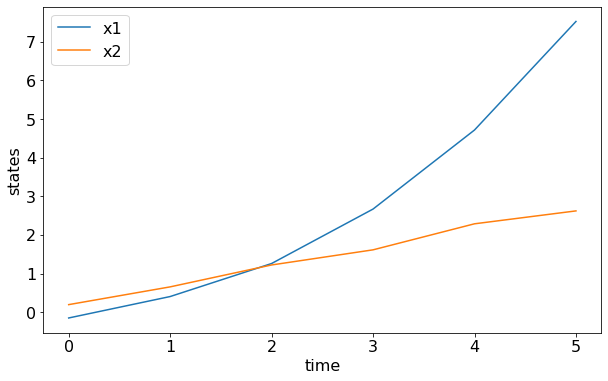

In [268]:
fig, ax = plt.subplots(figsize=(10,6))

# plot the states
lines = ax.plot(res_x.T)
ax.legend(lines, ['x1','x2'])

# Set labels
ax.set_ylabel('states')
ax.set_xlabel('time')

Defining the parameters and functions required for MPC

In [269]:
Q = np.identity(nx)
print(Q)
R = 0.1
R = np.diag(R*np.ones(nu))
print(R)

[[1. 0.]
 [0. 1.]]
[[0.1]]


In [270]:
N_horizon=25
N_sim=100
u_k=np.array([0.5])
x_0=np.array([-1.7,1.7]).reshape(2,1)

In [271]:
# stage cost
stage_cost = x.T@Q@x+ u.T@R@u
stage_cost_fcn = Function('stage_cost',[x,u],[stage_cost])

# terminal cost
terminal_cost = x.T@Q@x
terminal_cost_fcn = Function('terminal_cost',[x],[terminal_cost])

 #Upper and Lower bounds for stage variables

In [272]:
# state constraints
lb_x = -2*np.ones((nx,1))
ub_x = 2*np.ones((nx,1))
# input constraints
lb_u = -1*np.ones((nu,1))
ub_u = 1*np.ones((nu,1))

#Formulating MPC optimization problem

In [282]:
w_k=np.array([[0.25,0.25,-0.25,-0.25],[0.25,-0.25,0.25,-0.25]]).reshape(2,4)
w_0 = np.random.uniform(low=-0.25, high=0.25, size=(2,1))
N_cases=w_k.shape[1]

# MPC for single stage (with additive noise)

In [274]:
J=0
lb_X=[]
ub_X=[]
lb_U=[]
ub_U=[]
g=[]
lb_g=[]
ub_g=[]
X=SX.sym("X",(N_horizon+1)*nx,1)
U=SX.sym("U",(N_horizon)*nu,1)

for k in range(N_horizon):
    
    x_k = X[k*nx:(k+1)*nx,:]
    x_k_next = X[(k+1)*nx:(k+2)*nx,:]
    u_k = U[k*nu:(k+1)*nu,:]
    
    J+=stage_cost_fcn(x_k,u_k)
    
    x_k_next_calc=system(x_k,u_k,w_0)
    
    g.append(x_k_next - x_k_next_calc)
    lb_g.append(np.zeros((nx,1)))
    ub_g.append(np.zeros((nx,1)))
    
    
    lb_X.append(lb_x)
    ub_X.append(ub_x)
    
    lb_U.append(lb_u)
    ub_U.append(ub_u)
    

x_terminal=X[N_horizon*nx:(N_horizon+1)*nx]
J+=terminal_cost_fcn(x_terminal)
lb_X.append(lb_x)
ub_X.append(ub_x)

 #Create the CasADi solver for the optimization problem

x=vertcat(X,U)
lbx=vertcat(*lb_X,*lb_U)
ubx=vertcat(*ub_X,*ub_U)
g = vertcat(*g)
lbg = vertcat(*lb_g)
ubg = vertcat(*ub_g)

prob = {'f':J,'x':x,'g':g}
solver=nlpsol('solver','ipopt', prob)

#Creating and runnning the MPC loop
x_0=x_init
res_x1 = [x_0]
res_u1 = []



for i in range(N_sim):
    # fix initial condition of the state:
    lbx[:nx]=x_0
    ubx[:nx]=x_0
    # solve optimization problem
    res1 = solver(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg)
    u_k = res1['x'][(N_horizon+1)*nx:(N_horizon+1)*nx+nu,:]

    
    res_u1.append(u_k)
 
    
    # simulate the system
    x_next = system(x_0,u_k,w_0)
    res_x1.append(x_next)
    x_0 = x_next
    
# Make an array from the list of arrays:
res_x1 = np.concatenate(res_x1,axis=1)
res_u1 = np.concatenate(res_u1, axis=1)




This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       75

Total number of variables............................:       75
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       75
                     variables with only upper bounds:        0
Total number of equality constraints.................:       50
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       75

Total number of variables............................:       75
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       75
                     variables with only upper bounds:        0
Total number of equality constraints.................:       50
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8.8674279e-003 1.37e-001 0.00e+000  -1.0 0.00e+000    -  0.00e+00

   3 2.3714098e-001 2.78e-017 5.20e-017  -3.8 1.05e-003    -  1.00e+000 1.00e+000f  1
   4 2.3714098e-001 3.12e-017 7.21e-017  -5.7 7.19e-006    -  1.00e+000 1.00e+000h  1
   5 2.3714098e-001 2.78e-017 6.43e-017  -8.6 5.57e-008    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  2.3714098360984937e-001   2.3714098360984937e-001
Dual infeasibility......:  6.4284294982444243e-017   6.4284294982444243e-017
Constraint violation....:  2.7755575615628914e-017   2.7755575615628914e-017
Complementarity.........:  2.5059705371328258e-009   2.5059705371328258e-009
Overall NLP error.......:  2.5059705371328258e-009   2.5059705371328258e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constra

                     variables with only lower bounds:        0
                variables with lower and upper bounds:       75
                     variables with only upper bounds:        0
Total number of equality constraints.................:       50
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8.8675064e-003 1.37e-001 0.00e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.3759939e-001 2.78e-017 1.21e-003  -1.0 9.43e-002    -  9.93e-001 1.00e+000h  1
   2 2.3714258e-001 4.16e-017 5.90e-017  -2.5 1.41e-002    -  1.00e+000 1.00e+000f  1
   3 2.3714098e-001 2.78e-017 7.16e-017  -3.8 1.05e-003    -  1.00e+000 1.00e+000f  1
   4 2.3714098e-001 4.16e-017 7.21e-017  -5.7 7.19e-006    -  

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       75

Total number of variables............................:       75
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       75
                     variables with only upper bounds:        0
Total number of equality constraints.................:       50
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8.8675064e-003 1.37e-001 0.00e+000  -1.0 0.00e+000    -  0.00e+00

   1 2.3759939e-001 2.78e-017 1.21e-003  -1.0 9.43e-002    -  9.93e-001 1.00e+000h  1
   2 2.3714258e-001 4.16e-017 5.90e-017  -2.5 1.41e-002    -  1.00e+000 1.00e+000f  1
   3 2.3714098e-001 2.78e-017 7.16e-017  -3.8 1.05e-003    -  1.00e+000 1.00e+000f  1
   4 2.3714098e-001 4.16e-017 7.21e-017  -5.7 7.19e-006    -  1.00e+000 1.00e+000h  1
   5 2.3714098e-001 2.78e-017 6.43e-017  -8.6 5.57e-008    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  2.3714098360984937e-001   2.3714098360984937e-001
Dual infeasibility......:  6.4284294982444243e-017   6.4284294982444243e-017
Constraint violation....:  2.7755575615628914e-017   2.7755575615628914e-017
Complementarity.........:  2.5059705371328258e-009   2.5059705371328258e-009
Overall NLP error.......:  2.5059705371328258e-009   2.5059705371328258e-009


Number of objective function evaluations             = 6
Number of objective gradi

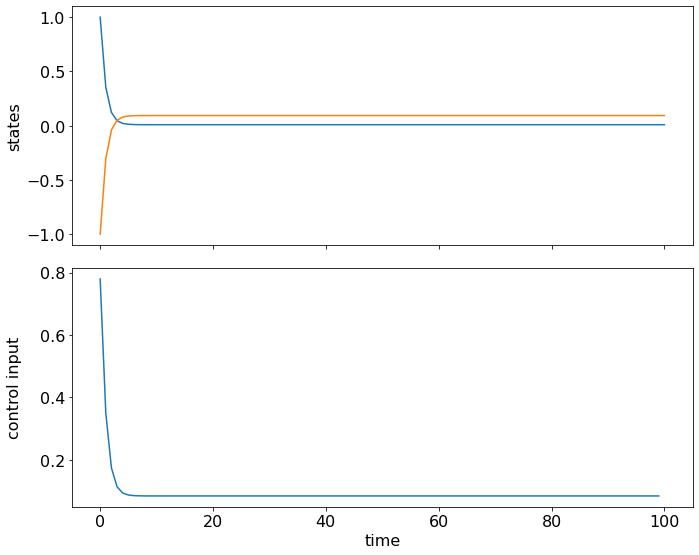

In [275]:
fig, ax = plt.subplots(2,1, figsize=(10,8), sharex=True)
ax[0].plot(res_x1.T)
ax[1].plot(res_u1.T)
ax[0].set_ylabel('states')
ax[1].set_ylabel('control input')
ax[1].set_xlabel('time')

fig.align_ylabels()
fig.tight_layout()

In [276]:
print(res1["g"].shape)
p1=np.array(res1["g"])
count1=np.count_nonzero(p1)
print("no of constraint violations = {}".format(count1))
print("cost = {}".format(res1['f']))
d1=count1/res1["g"].shape[0]
print("no of violations per contraint={}".format(d1))
print("settling values of states")
print(res_x1[0][-1],res_x1[1][-1])

(50, 1)
no of constraint violations = 37
cost = 0.237141
no of violations per contraint=0.74
settling values of states
0.009370010297713727 0.09370010297899867


# MPC for multistage with N_robust=1

In [277]:
n_robust=1

N=N_horizon-n_robust


In [278]:
 #Formulating MPC optimization problem
J=0
X=[]
U=[]
lb_X=[]
ub_X=[]
lb_U=[]
ub_U=[]
g=[]
lb_g=[]
ub_g=[]
g1 = []     # constraint expression g1(constraint of non-anticipativity )
lb_g1 = []  # lower bound for constraint expression g1
ub_g1 = []  #upper bound for constraint expression g1
nx=2
nu=1
#Defining Multistage tree structure

x0=SX.sym("X",nx,1)
X.append(x0)
for i in range (N_cases):
        x_case=SX.sym("X",(N+1)*nx,1)
        u_case=SX.sym("U",(N+1)*nu,1)
        X.append(x_case)
        U.append(u_case)


#Defining the MPC loop

for i in range(N_cases):
    x_k =X[0][0*nx:(0+1)*nx,:]
    x_k_next = X[i+1][(0)*nx:(0+1)*nx,:]
    u_k = U[0][0*nu:(0+1)*nu,:]
    J += stage_cost_fcn(x_k,u_k)
    x_k_next_calc =  system(x_k,u_k,w_k[:,i])
    g.append(x_k_next - x_k_next_calc)
    lb_g.append(np.zeros((nx,1)))
    ub_g.append(np.zeros((nx,1)))
    lb_U.append(lb_u)
    ub_U.append(ub_u)
    for k in range(N):
        
        x_k =X[i+1][k*nx:(k+1)*nx,:]
        x_k_next = X[i+1][(k+1)*nx:(k+2)*nx,:]
        u_k = U[i][(k+1)*nu:(k+2)*nu,:]
        
        J += stage_cost_fcn(x_k,u_k)
        
        x_k_next_calc =  system(x_k,u_k,w_k[:,i])
        
        g.append(x_k_next - x_k_next_calc)
        lb_g.append(np.zeros((nx,1)))
        ub_g.append(np.zeros((nx,1)))
        
        lb_X.append(lb_x)
        ub_X.append(ub_x)
        lb_U.append(lb_u)
        ub_U.append(ub_u)

    
    x_terminal = X[i+1][N*nx:(N+1)*nx,:]
    J += terminal_cost_fcn(x_terminal)
    lb_X.append(lb_x)
    ub_X.append(ub_x)
    if(i!=N_cases-1):
        g1.append(U[i][0*nu:(0+1)*nu,:]- U[i+1][0*nu:(0+1)*nu,:])
        lb_g1.append(np.zeros((nu,1)))
        ub_g1.append(np.zeros((nu,1)))


lb_X.append(lb_x)
ub_X.append(ub_x)

 #Create the CasADi solver for the optimization problem

lbx = vertcat(*lb_X, *lb_U)
ubx = vertcat(*ub_X, *ub_U)
x = vertcat(*X,*U)
g = vertcat(*g,*g1)
lbg = vertcat(*lb_g,*lb_g1)
ubg = vertcat(*ub_g,*lb_g1)

prob = {'f':J,'x':x,'g':g}
solver = nlpsol('solver','ipopt',prob)



In [279]:
 #Creating and runninng the MPC main loop
nX=len(lb_X)
nU=len(lb_U)
x_0=x_init
res_x2 = [x_0]
res_u2 = []

for i in range(N_sim):
    # fix initial condition of the state:
    lbx[:nx]=x_0
    ubx[:nx]=x_0
    # solve optimization problem
    res2 = solver(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg)
    # u_k = res['x'][(N_cases*(N+1))*nx:(N_cases*(N+1))*nx+nu,:]
    u_k=res2['x'][(N_cases*(N+1)*nx)+nx:(N_cases*(N+1))*nx+nx+nu,:]
    #u_k=res['x'][nX*nx:(nX*nx)+nu,:]
    res_u2.append(u_k)
    # simulate the system
    x_next = system(x_0,u_k,w_0)
    
    res_x2.append(x_next)
    x_0 = x_next
    
# Make an array from the list of arrays:
res_x2 = np.concatenate(res_x2,axis=1)
res_u2 = np.concatenate(res_u2, axis=1)


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      694
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      297

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      203
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

   8 1.0919279e+001 1.11e-016 4.85e-016  -8.6 1.21e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:  1.0919278982200016e+001   1.0919278982200016e+001
Dual infeasibility......:  4.8531663273353436e-016   4.8531663273353436e-016
Constraint violation....:  1.1102230246251565e-016   1.1102230246251565e-016
Complementarity.........:  2.9443438346380535e-009   2.9443438346380535e-009
Overall NLP error.......:  2.9443438346380535e-009   2.9443438346380535e-009


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 9
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 9
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 8
Total CPU secs in IPOPT (w/

   6 1.1047348e+001 1.11e-016 4.82e-016  -5.7 1.97e-003    -  1.00e+000 1.00e+000f  1
   7 1.1047335e+001 1.11e-016 6.59e-016  -8.6 7.25e-005    -  1.00e+000 1.00e+000f  1
   8 1.1047335e+001 1.11e-016 2.78e-016  -9.0 9.22e-008    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:  1.1047334730257589e+001   1.1047334730257589e+001
Dual infeasibility......:  2.7837617808285215e-016   2.7837617808285215e-016
Constraint violation....:  1.1102230246251565e-016   1.1102230246251565e-016
Complementarity.........:  9.0911600109604846e-010   9.0911600109604846e-010
Overall NLP error.......:  9.0911600109604846e-010   9.0911600109604846e-010


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 9
Number of inequality constraint evaluations          = 0
Number of equality constra

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      203
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6.1561734e-001 5.25e-001 0.00e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 1.1216527e+001 1.11e-016 7.94e-001  -1.0 8.89e-001    -  5.53e-001 1.00e+000h  1
   2 1.1098972e+001 9.71e-017 2.74e-002  -1.7 7.56e-002    -  9.56e-001 1.00e+000f  1
   3 1.1056498e+001 1.11e-016 3.33e-016  -2.5 8.30e-002    -  1.00e+000 1.00e+000f  1
   4 1.1049539e+001 8.33e-017 5.18e-016  -3.8 3.03e-002    -  

   7 1.1047370e+001 1.11e-016 4.46e-016  -8.6 7.24e-005    -  1.00e+000 1.00e+000f  1
   8 1.1047370e+001 1.11e-016 2.66e-016  -9.0 9.22e-008    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:  1.1047369715678542e+001   1.1047369715678542e+001
Dual infeasibility......:  2.6600935694922311e-016   2.6600935694922311e-016
Constraint violation....:  1.1102230246251565e-016   1.1102230246251565e-016
Complementarity.........:  9.0911598187431304e-010   9.0911598187431304e-010
Overall NLP error.......:  9.0911598187431304e-010   9.0911598187431304e-010


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 9
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 9
Number of inequality constraint Jacobian evaluations = 

   4 1.1049539e+001 1.11e-016 3.30e-016  -3.8 3.03e-002    -  1.00e+000 1.00e+000f  1
   5 1.1047745e+001 1.11e-016 6.42e-016  -3.8 8.99e-003    -  1.00e+000 1.00e+000f  1
   6 1.1047383e+001 1.11e-016 8.26e-016  -5.7 1.97e-003    -  1.00e+000 1.00e+000f  1
   7 1.1047370e+001 1.11e-016 2.67e-016  -8.6 7.24e-005    -  1.00e+000 1.00e+000f  1
   8 1.1047370e+001 1.11e-016 3.20e-016  -9.0 9.22e-008    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:  1.1047369715726987e+001   1.1047369715726987e+001
Dual infeasibility......:  3.1980044244835615e-016   3.1980044244835615e-016
Constraint violation....:  1.1102230246251565e-016   1.1102230246251565e-016
Complementarity.........:  9.0911598191245878e-010   9.0911598191245878e-010
Overall NLP error.......:  9.0911598191245878e-010   9.0911598191245878e-010


Number of objective function evaluations             = 9
Number of objective gradi

   6 1.1047383e+001 1.11e-016 5.77e-016  -5.7 1.97e-003    -  1.00e+000 1.00e+000f  1
   7 1.1047370e+001 1.11e-016 4.03e-016  -8.6 7.24e-005    -  1.00e+000 1.00e+000f  1
   8 1.1047370e+001 1.11e-016 4.57e-016  -9.0 9.22e-008    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:  1.1047369715727246e+001   1.1047369715727246e+001
Dual infeasibility......:  4.5747302359403388e-016   4.5747302359403388e-016
Constraint violation....:  1.1102230246251565e-016   1.1102230246251565e-016
Complementarity.........:  9.0911598191266248e-010   9.0911598191266248e-010
Overall NLP error.......:  9.0911598191266248e-010   9.0911598191266248e-010


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 9
Number of inequality constraint evaluations          = 0
Number of equality constra

   2 1.1098972e+001 1.11e-016 2.74e-002  -1.7 7.56e-002    -  9.56e-001 1.00e+000f  1
   3 1.1056498e+001 1.11e-016 4.54e-016  -2.5 8.30e-002    -  1.00e+000 1.00e+000f  1
   4 1.1049539e+001 1.11e-016 6.96e-016  -3.8 3.03e-002    -  1.00e+000 1.00e+000f  1
   5 1.1047745e+001 1.11e-016 2.83e-016  -3.8 8.99e-003    -  1.00e+000 1.00e+000f  1
   6 1.1047383e+001 1.11e-016 5.77e-016  -5.7 1.97e-003    -  1.00e+000 1.00e+000f  1
   7 1.1047370e+001 1.11e-016 4.03e-016  -8.6 7.24e-005    -  1.00e+000 1.00e+000f  1
   8 1.1047370e+001 1.11e-016 4.57e-016  -9.0 9.22e-008    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:  1.1047369715727246e+001   1.1047369715727246e+001
Dual infeasibility......:  4.5747302359403388e-016   4.5747302359403388e-016
Constraint violation....:  1.1102230246251565e-016   1.1102230246251565e-016
Complementarity.........:  9.0911598191266248e-010   9.09115981912

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      203
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6.1561739e-001 5.25e-001 0.00e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 1.1216527e+001 1.11e-016 7.94e-001  -1.0 8.89e-001    -  5.53e-001 1.00e+000h  1
   2 1.1098972e+001 1.11e-016 2.74e-002  -1.7 7.56e-002    -  9.56e-001 1.00e+000f  1
   3 1.1056498e+001 1.11e-016 4.54e-016  -2.5 8.30e-002    -  1.00e+000 1.00e+000f  1
   4 1.1049539e+001 1.11e-016 6.96e-016  -3.8 3.03e-002    -  

   6 1.1047383e+001 8.33e-017 1.05e-015  -5.7 1.97e-003    -  1.00e+000 1.00e+000f  1
   7 1.1047370e+001 1.67e-016 6.10e-016  -8.6 7.24e-005    -  1.00e+000 1.00e+000f  1
   8 1.1047370e+001 1.11e-016 3.92e-016  -9.0 9.22e-008    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:  1.1047369715727244e+001   1.1047369715727244e+001
Dual infeasibility......:  3.9226863152461156e-016   3.9226863152461156e-016
Constraint violation....:  1.1102230246251565e-016   1.1102230246251565e-016
Complementarity.........:  9.0911598191266248e-010   9.0911598191266248e-010
Overall NLP error.......:  9.0911598191266248e-010   9.0911598191266248e-010


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 9
Number of inequality constraint evaluations          = 0
Number of equality constra

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      203
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6.1561739e-001 5.25e-001 0.00e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 1.1216527e+001 1.04e-016 7.94e-001  -1.0 8.89e-001    -  5.53e-001 1.00e+000h  1
   2 1.1098972e+001 1.11e-016 2.74e-002  -1.7 7.56e-002    -  9.56e-001 1.00e+000f  1
   3 1.1056498e+001 1.11e-016 5.41e-016  -2.5 8.30e-002    -  1.00e+000 1.00e+000f  1
   4 1.1049539e+001 1.11e-016 3.14e-016  -3.8 3.03e-002    -  

   4 1.1049539e+001 1.11e-016 3.14e-016  -3.8 3.03e-002    -  1.00e+000 1.00e+000f  1
   5 1.1047745e+001 1.18e-016 5.25e-016  -3.8 8.99e-003    -  1.00e+000 1.00e+000f  1
   6 1.1047383e+001 8.33e-017 1.05e-015  -5.7 1.97e-003    -  1.00e+000 1.00e+000f  1
   7 1.1047370e+001 1.67e-016 6.10e-016  -8.6 7.24e-005    -  1.00e+000 1.00e+000f  1
   8 1.1047370e+001 1.11e-016 3.92e-016  -9.0 9.22e-008    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:  1.1047369715727244e+001   1.1047369715727244e+001
Dual infeasibility......:  3.9226863152461156e-016   3.9226863152461156e-016
Constraint violation....:  1.1102230246251565e-016   1.1102230246251565e-016
Complementarity.........:  9.0911598191266248e-010   9.0911598191266248e-010
Overall NLP error.......:  9.0911598191266248e-010   9.0911598191266248e-010


Number of objective function evaluations             = 9
Number of objective gradi

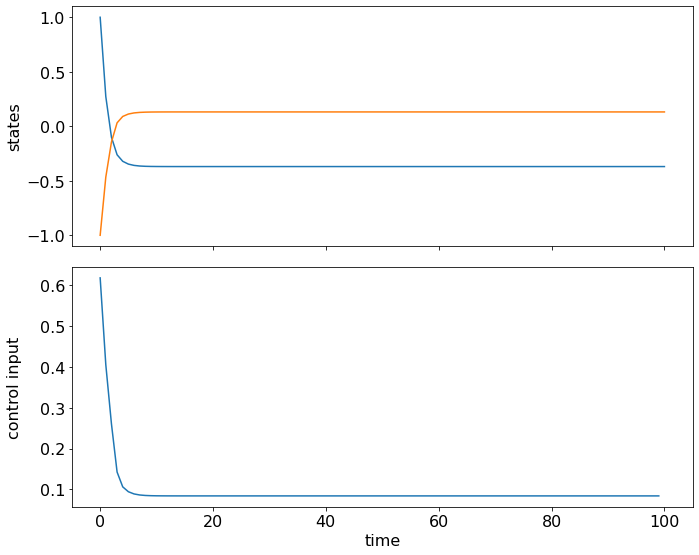

In [280]:
fig, ax = plt.subplots(2,1, figsize=(10,8), sharex=True)
ax[0].plot(res_x2.T)
ax[1].plot(res_u2.T)
ax[0].set_ylabel('states')
ax[1].set_ylabel('control input')
ax[1].set_xlabel('time')

fig.align_ylabels()
fig.tight_layout()

In [281]:
print(res2["g"].shape)
p2=np.array(res2["g"])
count2=np.count_nonzero(p2)
print("no of constraint violations = {}".format(count2))
print("cost = {}".format(res2['f']))
d2=count2/res2["g"].shape[0]
print("no of violations per contraint={}".format(d2))
print("settling values of states")
print(res_x2[0][-1],res_x2[1][-1])

(203, 1)
no of constraint violations = 147
cost = 0.237141
no of violations per contraint=0.7241379310344828
settling values of states
-0.36957699599559235 0.13159480360832937


# MPC for multistage with N_robust=2

In [ ]:
n_robust=2
N=N_horizon-n_robust

In [283]:
#Formulating MPC optimization problem

J = 0
X=[]
U=[]
lb_X = [] 
ub_X = [] 
lb_U = [] 
ub_U = [] 
g = []    
lb_g = []  
ub_g = []   
g1 = []     # constraint expression g1(constraint of non-anticipativity )
lb_g1 = []  # lower bound for constraint expression g1
ub_g1 = []  #upper bound for constraint expression g1


 #Defining Multistage tree structure


x0=SX.sym("X",nx,1)
u0=SX.sym("U",N_cases*nu,1)
X.append(x0)
U.append(u0)
for j in range (N_cases):
    x0=SX.sym("X",nx,1)
    u0=SX.sym("U",N_cases*nu,1)
    X.append(x0)
    U.append(u0)

    for i in range (N_cases):
        x_case=SX.sym("X",(N+1)*nx,1)
        u_case=SX.sym("U",(N)*nu,1)
        X.append(x_case)
        U.append(u_case)


    #Defining the MPC loop


for k in range(N_cases):

    x_k =X[0][0*nx:(0+1)*nx,:]
    x_k_next = X[(N_cases)*k+(k+1)][(0)*nx:(0+1)*nx,:]
    u_k = U[0][k*nu:(k+1)*nu,:]

    J += stage_cost_fcn(x_k,u_k)

    x_k_next_calc =  system(x_k,u_k,w_k[:,k])

    g.append(x_k_next - x_k_next_calc)
    lb_g.append(np.zeros((nx,1)))
    ub_g.append(np.zeros((nx,1)))

    lb_X.append(lb_x)
    ub_X.append(ub_x)
    lb_U.append(lb_u)
    ub_U.append(ub_u)

    if(k!=N_cases-1):
        g1.append(U[0][k*nu:(k+1)*nu,:]- U[0][(k+1)*nu:(k+2)*nu,:])
        lb_g1.append(np.zeros((nu,1)))
        ub_g1.append(np.zeros((nu,1)))

    for i in range(N_cases):

        x_k =X[(N_cases)*k+(k+1)][(0)*nx:(0+1)*nx,:]
        x_k_next = X[i+2+(k*5)][(0)*nx:(0+1)*nx,:]
        u_k = U[(N_cases)*k+(k+1)][i*nu:(i+1)*nu,:]

        J += stage_cost_fcn(x_k,u_k)

        x_k_next_calc =  system(x_k,u_k,w_k[:,i])

        g.append(x_k_next - x_k_next_calc)
        lb_g.append(np.zeros((nx,1)))
        ub_g.append(np.zeros((nx,1)))

        lb_X.append(lb_x)
        ub_X.append(ub_x)
        lb_U.append(lb_u)
        ub_U.append(ub_u)

        if(i!=N_cases-1):
            g1.append(U[(N_cases)*k+(k+1)][i*nu:(i+1)*nu,:]- U[(N_cases)*k+(k+1)][(i+1)*nu:(i+2)*nu,:])
            lb_g1.append(np.zeros((nu,1)))
            ub_g1.append(np.zeros((nu,1)))

        for j in range(N):

            x_k =X[i+2+(k*5)][(j)*nx:(j+1)*nx,:]
            x_k_next = X[i+2+(k*5)][(j+1)*nx:(j+2)*nx,:]
            u_k = U[i+2+(k*5)][j*nu:(j+1)*nu,:]

            J += stage_cost_fcn(x_k,u_k)

            x_k_next_calc =  system(x_k,u_k,w_k[:,i])

            g.append(x_k_next - x_k_next_calc)
            lb_g.append(np.zeros((nx,1)))
            ub_g.append(np.zeros((nx,1)))

            lb_X.append(lb_x)
            ub_X.append(ub_x)
            lb_U.append(lb_u)
            ub_U.append(ub_u)

        x_terminal = X[i+2+(k*5)][N*nx:(N+1)*nx,:]
        J += terminal_cost_fcn(x_terminal)




lb_X.append(lb_x)
ub_X.append(ub_x)

#Create the CasADi solver for the optimization problem

lbx = vertcat(*lb_X, *lb_U)
ubx = vertcat(*ub_X, *ub_U)
x = vertcat(*X,*U)
g = vertcat(*g,*g1)
lbg = vertcat(*lb_g,*lb_g1)
ubg = vertcat(*ub_g,*ub_g1)

prob = {'f':J,'x':x,'g':g}
solver = nlpsol('solver','ipopt',prob)


nX=len(lb_X)
nU=len(lb_U)


#Creating and runninng the MPC main loop

x_0=x_init
res_x3 = [x_0]
res_u3 = []


for i in range(N_sim):
    # fix initial condition of the state:
    lbx[:nx]=x_0
    ubx[:nx]=x_0
    # solve optimization problem
    lbg=0
    ubg=0
    res3 = solver(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg)
    # u_k = res['x'][(N_cases*(N+1))*nx:(N_cases*(N+1))*nx+nu,:]
    u_k=res3['x'][nX*nx:(nX*nx)+nu,:]
    res_u3.append(u_k)
    # simulate the system
    x_next = system(x_0,u_k,w_0)
    print(x_0)

    res_x3.append(x_next)
    x_0 = x_next

# Make an array from the list of arrays:
res_x3 = np.concatenate(res_x3,axis=1)
res_u3 = np.concatenate(res_u3, axis=1)


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2846
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1212

Total number of variables............................:     1212
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1212
                     variables with only upper bounds:        0
Total number of equality constraints.................:      823
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

Total number of variables............................:     1212
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1212
                     variables with only upper bounds:        0
Total number of equality constraints.................:      823
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3.9247598e-001 4.99e-001 0.00e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 4.6192197e+001 1.67e-016 8.71e-001  -1.0 9.42e-001    -  5.38e-001 1.00e+000h  1
   2 4.5601239e+001 1.67e-016 4.67e-002  -1.7 8.19e-002    -  9.39e-001 1.00e+000f  1
   3 4.5397652e+001 1.39e-016 1.63e-015  -2.5 9.08e-002    -  1.00e+000 1.00e+000f  

Complementarity.........:  9.5490174848848466e-009   9.5490174848848466e-009
Overall NLP error.......:  9.5490174848848466e-009   9.5490174848848466e-009


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.028
Total CPU secs in NLP function evaluations           =      0.002

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        11
       nlp_g  |   2.00ms (181.82us)   2.00ms (182.18us)        11
  nlp_grad_f  |        0 (       0)        0 (       0)        12
  nlp_hess_l 

                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1212
                     variables with only upper bounds:        0
Total number of equality constraints.................:      823
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3.9229966e-001 4.99e-001 0.00e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 4.6191710e+001 1.11e-016 8.71e-001  -1.0 9.42e-001    -  5.38e-001 1.00e+000h  1
   2 4.5600752e+001 1.18e-016 4.67e-002  -1.7 8.19e-002    -  9.39e-001 1.00e+000f  1
   3 4.5397165e+001 1.11e-016 9.02e-016  -2.5 9.08e-002    -  1.00e+000 1.00e+000f  1
   4 4.5370814e+001 1.11e-016 4.55e-003  -3.8 3.97e-002    -  

   6 4.5365040e+001 1.67e-016 4.33e-004  -5.7 1.01e-002    -  9.86e-001 1.00e+000f  1
   7 4.5364858e+001 1.11e-016 1.78e-015  -5.7 4.76e-003    -  1.00e+000 1.00e+000f  1
   8 4.5364809e+001 1.11e-016 2.60e-015  -5.7 1.97e-003    -  1.00e+000 1.00e+000f  1
   9 4.5364794e+001 1.67e-016 1.41e-007  -8.6 5.72e-004    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.5364793e+001 1.67e-016 1.49e-015  -8.6 4.86e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:  4.5364792809432700e+001   4.5364792809432700e+001
Dual infeasibility......:  1.4898088886248859e-015   1.4898088886248859e-015
Constraint violation....:  1.6653345369377348e-016   1.6653345369377348e-016
Complementarity.........:  9.5490038823187361e-009   9.5490038823187361e-009
Overall NLP error.......:  9.5490038823187361e-009   9.5490038823187361e-009




   8 4.5364809e+001 1.67e-016 1.27e-015  -5.7 1.97e-003    -  1.00e+000 1.00e+000f  1
   9 4.5364794e+001 1.39e-016 1.41e-007  -8.6 5.72e-004    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.5364793e+001 1.16e-016 1.87e-015  -8.6 4.86e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:  4.5364792809432622e+001   4.5364792809432622e+001
Dual infeasibility......:  1.8733049673154612e-015   1.8733049673154612e-015
Constraint violation....:  1.1600963245594897e-016   1.1600963245594897e-016
Complementarity.........:  9.5490038823203193e-009   9.5490038823203193e-009
Overall NLP error.......:  9.5490038823203193e-009   9.5490038823203193e-009


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 1

                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1212
                     variables with only upper bounds:        0
Total number of equality constraints.................:      823
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3.9229966e-001 4.99e-001 0.00e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 4.6191710e+001 1.11e-016 8.71e-001  -1.0 9.42e-001    -  5.38e-001 1.00e+000h  1
   2 4.5600752e+001 1.67e-016 4.67e-002  -1.7 8.19e-002    -  9.39e-001 1.00e+000f  1
   3 4.5397165e+001 1.11e-016 1.04e-015  -2.5 9.08e-002    -  1.00e+000 1.00e+000f  1
   4 4.5370814e+001 1.25e-016 4.55e-003  -3.8 3.97e-002    -  

  10 4.5364793e+001 1.18e-016 1.11e-015  -8.6 4.86e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:  4.5364792809432622e+001   4.5364792809432622e+001
Dual infeasibility......:  1.1141328199354318e-015   1.1141328199354318e-015
Constraint violation....:  1.1796119636642288e-016   1.1796119636642288e-016
Complementarity.........:  9.5490038823204119e-009   9.5490038823204119e-009
Overall NLP error.......:  9.5490038823204119e-009   9.5490038823204119e-009


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPO

   7 4.5364858e+001 1.67e-016 1.22e-015  -5.7 4.76e-003    -  1.00e+000 1.00e+000f  1
   8 4.5364809e+001 1.67e-016 9.39e-016  -5.7 1.97e-003    -  1.00e+000 1.00e+000f  1
   9 4.5364794e+001 1.39e-016 1.41e-007  -8.6 5.72e-004    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.5364793e+001 1.18e-016 1.11e-015  -8.6 4.86e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:  4.5364792809432622e+001   4.5364792809432622e+001
Dual infeasibility......:  1.1141328199354318e-015   1.1141328199354318e-015
Constraint violation....:  1.1796119636642288e-016   1.1796119636642288e-016
Complementarity.........:  9.5490038823204119e-009   9.5490038823204119e-009
Overall NLP error.......:  9.5490038823204119e-009   9.5490038823204119e-009


Number of objective function evaluations             = 11
Number of objective gradient

   8 4.5364809e+001 1.67e-016 9.39e-016  -5.7 1.97e-003    -  1.00e+000 1.00e+000f  1
   9 4.5364794e+001 1.39e-016 1.41e-007  -8.6 5.72e-004    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.5364793e+001 1.18e-016 1.11e-015  -8.6 4.86e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:  4.5364792809432622e+001   4.5364792809432622e+001
Dual infeasibility......:  1.1141328199354318e-015   1.1141328199354318e-015
Constraint violation....:  1.1796119636642288e-016   1.1796119636642288e-016
Complementarity.........:  9.5490038823204119e-009   9.5490038823204119e-009
Overall NLP error.......:  9.5490038823204119e-009   9.5490038823204119e-009


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 1

   5 4.5366160e+001 1.11e-016 3.34e-015  -3.8 1.84e-002    -  1.00e+000 1.00e+000f  1
   6 4.5365040e+001 1.11e-016 4.33e-004  -5.7 1.01e-002    -  9.86e-001 1.00e+000f  1
   7 4.5364858e+001 1.67e-016 1.22e-015  -5.7 4.76e-003    -  1.00e+000 1.00e+000f  1
   8 4.5364809e+001 1.67e-016 9.39e-016  -5.7 1.97e-003    -  1.00e+000 1.00e+000f  1
   9 4.5364794e+001 1.39e-016 1.41e-007  -8.6 5.72e-004    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.5364793e+001 1.18e-016 1.11e-015  -8.6 4.86e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:  4.5364792809432622e+001   4.5364792809432622e+001
Dual infeasibility......:  1.1141328199354318e-015   1.1141328199354318e-015
Constraint violation....:  1.1796119636642288e-016   1.1796119636642288e-016
Complementarity.........:  9.5490038823204119e-009   9.549003882320411

   3 4.5397165e+001 1.11e-016 1.04e-015  -2.5 9.08e-002    -  1.00e+000 1.00e+000f  1
   4 4.5370814e+001 1.25e-016 4.55e-003  -3.8 3.97e-002    -  9.59e-001 1.00e+000f  1
   5 4.5366160e+001 1.11e-016 3.34e-015  -3.8 1.84e-002    -  1.00e+000 1.00e+000f  1
   6 4.5365040e+001 1.11e-016 4.33e-004  -5.7 1.01e-002    -  9.86e-001 1.00e+000f  1
   7 4.5364858e+001 1.67e-016 1.22e-015  -5.7 4.76e-003    -  1.00e+000 1.00e+000f  1
   8 4.5364809e+001 1.67e-016 9.39e-016  -5.7 1.97e-003    -  1.00e+000 1.00e+000f  1
   9 4.5364794e+001 1.39e-016 1.41e-007  -8.6 5.72e-004    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.5364793e+001 1.18e-016 1.11e-015  -8.6 4.86e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:  4.5364792809432622e+001   4.5364792809432622e+001
Dual infeasibility......:  1.1141328199354318e-015  

   5 4.5366160e+001 1.11e-016 3.34e-015  -3.8 1.84e-002    -  1.00e+000 1.00e+000f  1
   6 4.5365040e+001 1.11e-016 4.33e-004  -5.7 1.01e-002    -  9.86e-001 1.00e+000f  1
   7 4.5364858e+001 1.67e-016 1.22e-015  -5.7 4.76e-003    -  1.00e+000 1.00e+000f  1
   8 4.5364809e+001 1.67e-016 9.39e-016  -5.7 1.97e-003    -  1.00e+000 1.00e+000f  1
   9 4.5364794e+001 1.39e-016 1.41e-007  -8.6 5.72e-004    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.5364793e+001 1.18e-016 1.11e-015  -8.6 4.86e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:  4.5364792809432622e+001   4.5364792809432622e+001
Dual infeasibility......:  1.1141328199354318e-015   1.1141328199354318e-015
Constraint violation....:  1.1796119636642288e-016   1.1796119636642288e-016
Complementarity.........:  9.5490038823204119e-009   9.549003882320411

   3 4.5397165e+001 1.11e-016 1.04e-015  -2.5 9.08e-002    -  1.00e+000 1.00e+000f  1
   4 4.5370814e+001 1.25e-016 4.55e-003  -3.8 3.97e-002    -  9.59e-001 1.00e+000f  1
   5 4.5366160e+001 1.11e-016 3.34e-015  -3.8 1.84e-002    -  1.00e+000 1.00e+000f  1
   6 4.5365040e+001 1.11e-016 4.33e-004  -5.7 1.01e-002    -  9.86e-001 1.00e+000f  1
   7 4.5364858e+001 1.67e-016 1.22e-015  -5.7 4.76e-003    -  1.00e+000 1.00e+000f  1
   8 4.5364809e+001 1.67e-016 9.39e-016  -5.7 1.97e-003    -  1.00e+000 1.00e+000f  1
   9 4.5364794e+001 1.39e-016 1.41e-007  -8.6 5.72e-004    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.5364793e+001 1.18e-016 1.11e-015  -8.6 4.86e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:  4.5364792809432622e+001   4.5364792809432622e+001
Dual infeasibility......:  1.1141328199354318e-015  

   1 4.6191710e+001 1.11e-016 8.71e-001  -1.0 9.42e-001    -  5.38e-001 1.00e+000h  1
   2 4.5600752e+001 1.67e-016 4.67e-002  -1.7 8.19e-002    -  9.39e-001 1.00e+000f  1
   3 4.5397165e+001 1.11e-016 1.04e-015  -2.5 9.08e-002    -  1.00e+000 1.00e+000f  1
   4 4.5370814e+001 1.25e-016 4.55e-003  -3.8 3.97e-002    -  9.59e-001 1.00e+000f  1
   5 4.5366160e+001 1.11e-016 3.34e-015  -3.8 1.84e-002    -  1.00e+000 1.00e+000f  1
   6 4.5365040e+001 1.11e-016 4.33e-004  -5.7 1.01e-002    -  9.86e-001 1.00e+000f  1
   7 4.5364858e+001 1.67e-016 1.22e-015  -5.7 4.76e-003    -  1.00e+000 1.00e+000f  1
   8 4.5364809e+001 1.67e-016 9.39e-016  -5.7 1.97e-003    -  1.00e+000 1.00e+000f  1
   9 4.5364794e+001 1.39e-016 1.41e-007  -8.6 5.72e-004    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.5364793e+001 1.18e-016 1.11e-015  -8.6 4.86e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 10

                            

   2 4.5600752e+001 1.67e-016 4.67e-002  -1.7 8.19e-002    -  9.39e-001 1.00e+000f  1
   3 4.5397165e+001 1.11e-016 1.04e-015  -2.5 9.08e-002    -  1.00e+000 1.00e+000f  1
   4 4.5370814e+001 1.25e-016 4.55e-003  -3.8 3.97e-002    -  9.59e-001 1.00e+000f  1
   5 4.5366160e+001 1.11e-016 3.34e-015  -3.8 1.84e-002    -  1.00e+000 1.00e+000f  1
   6 4.5365040e+001 1.11e-016 4.33e-004  -5.7 1.01e-002    -  9.86e-001 1.00e+000f  1
   7 4.5364858e+001 1.67e-016 1.22e-015  -5.7 4.76e-003    -  1.00e+000 1.00e+000f  1
   8 4.5364809e+001 1.67e-016 9.39e-016  -5.7 1.97e-003    -  1.00e+000 1.00e+000f  1
   9 4.5364794e+001 1.39e-016 1.41e-007  -8.6 5.72e-004    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.5364793e+001 1.18e-016 1.11e-015  -8.6 4.86e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:  4.53647928094326

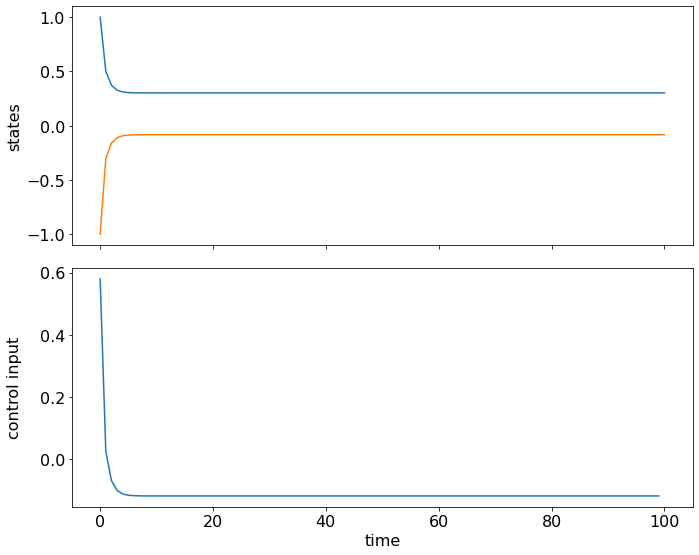

In [284]:
fig, ax = plt.subplots(2,1, figsize=(10,8), sharex=True)
ax[0].plot(res_x3.T)
ax[1].plot(res_u3.T)
ax[0].set_ylabel('states')
ax[1].set_ylabel('control input')
ax[1].set_xlabel('time')

fig.align_ylabels()
fig.tight_layout()

In [285]:
print(res3["g"].shape)
p3=np.array(res3["g"])
count3=np.count_nonzero(p3)
print("no of constraint violations = {}".format(count3))
print("cost = {}".format(res3['f']))
d3=count3/res3["g"].shape[0]
print("no of violations per contraint={}".format(d3))
print("settling values of states")
print(res_x3[0][-1],res_x3[1][-1])

(823, 1)
no of constraint violations = 582
cost = 45.3648
no of violations per contraint=0.707168894289186
settling values of states
0.3019924757089689 -0.08291839023798431
